In [1]:
import os
import sys
sys.path.extend(["../..", "."])

from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, "..", "..")

from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import allign_metrics, report_alligned_metrics, get_roc, get_preds
from nebula.misc.plots import plot_roc_curve, plot_cv_metrics_dict
from nebula.models.neurlux import NeurLuxModel
from nebula.models import TransformerEncoderChunks
from collections import defaultdict
import numpy as np
from pandas import read_csv
import pickle
import json
import torch

label_file = os.path.join(REPO_ROOT, r"data\data_raw\Avast\Public_Avast_CTU_CAPEv2_Dataset_Small\public_labels.csv")
LABEL_FIELD = 'classification_family'
LABEL_TABLE = read_csv(label_file)
LABEL_MAP = dict(zip(
    sorted(LABEL_TABLE[LABEL_FIELD].unique()),
    list(range(LABEL_TABLE[LABEL_FIELD].nunique()))
))
REVERSE_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}

RUN_TYPES = ["nebula_bpe", "nebula_wht", "neurlux"]
RUN_NAME = "avast"

INFOLDER = "out_avast_multiclass"

RUN_END_FILTER = "r1763_t5"
run_folders = [x for x in os.listdir(INFOLDER) if x.startswith("cv") and x.endswith(RUN_END_FILTER)]

NEBULA_VOCAB = 50000
NEURLUX_VOCAB = 10000
SEQ_LEN = 512
LIMIT = "full"

In [2]:
models = defaultdict(dict)

neurlux_vocab_file = os.path.join(INFOLDER, f"neurlux_{RUN_NAME}_vocab_{NEURLUX_VOCAB}_seqlen_{SEQ_LEN}", f"vocab_{NEURLUX_VOCAB}.json")

nebula_bpe_vocab_file = os.path.join(INFOLDER, f"nebula_bpe_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")
nebula_wht_vocab_file = os.path.join(INFOLDER, f"nebula_wht_{RUN_NAME}_vocab_{NEBULA_VOCAB}_seqlen_{SEQ_LEN}", f"tokenizer_{NEBULA_VOCAB}_vocab.json")

num_classes = len(LABEL_MAP)

with open(neurlux_vocab_file) as f:
    neurlux_vocab = json.load(f)
models['neurlux']['class'] = NeurLuxModel
models['neurlux']['config'] = {
    "embedding_dim": 256,
    "vocab_size": len(neurlux_vocab),
    "seq_len": SEQ_LEN,
    "num_classes": num_classes
}

with open(nebula_bpe_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula_bpe']['class'] = TransformerEncoderChunks
models['nebula_bpe']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": num_classes, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}

with open(nebula_wht_vocab_file) as f:
    nebula_vocab = json.load(f)
models['nebula_wht']['class'] = TransformerEncoderChunks
models['nebula_wht']['config'] = {
    "vocab_size": len(nebula_vocab),
    "maxlen": SEQ_LEN,
    "chunk_size": 64,
    "dModel": 64,  # embedding & transformer dimension
    "nHeads": 8,  # number of heads in nn.MultiheadAttention
    "dHidden": 256,  # dimension of the feedforward network model in nn.TransformerEncoder
    "nLayers": 2,  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
    "numClasses": num_classes, # binary classification
    "hiddenNeurons": [64],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False,
    "norm_first": True
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
metrics_val = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = "_".join(folder.split("_")[1:3]).replace("_lim500", "").replace("_limNone", "")
    
    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_val_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
        print(f"[!] Loaded existing metrics from: {existing_pickle}")
    else:
        print(f"[!] In process: {key}")
        metrics = defaultdict(list)
        folder = os.path.join(INFOLDER, folder)
        print(f"[*] Reading data splits from: {folder}")
        data_splits = read_cv_data_splits(folder)
        
        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]
        
        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                data_splits[i]["X_test"],
                data_splits[i]["y_test"],
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_LABEL_MAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_val[key] = metrics

[!] Loaded existing metrics from: out_avast_multiclass\nebula_bpe_roc_metrics_val_r1763_t5.pkl
[!] Loaded existing metrics from: out_avast_multiclass\nebula_wht_roc_metrics_val_r1763_t5.pkl
[!] Loaded existing metrics from: out_avast_multiclass\neurlux_roc_metrics_val_r1763_t5.pkl


Adload
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.968565  0.983976  0.968495  0.968549   0.968728  0.998827
nebula_wht  0.976790  0.988118  0.973789  0.976779   0.971022  0.999040
neurlux     0.992710  0.996324  0.995014  0.992702   0.997354  0.999813
Emotet
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.457241  0.996211  0.993550  0.996143   0.990996  0.996241
nebula_wht  0.260138  0.995812  0.992915  0.995685   0.990169  0.995868
neurlux     0.732856  0.996760  0.995727  0.994949   0.996508  0.997521
HarHar
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.996478  0.998183  0.994955  0.996475   0.993460  0.999840
nebula_wht  0.996478  0.998197  0.995791  0.996475   0.995127  0.999867
neurlux     1.000000  0.999959  0.997522  1.000000   0.995064  0.999920
Lokibot
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.323075  0.972931  0.9

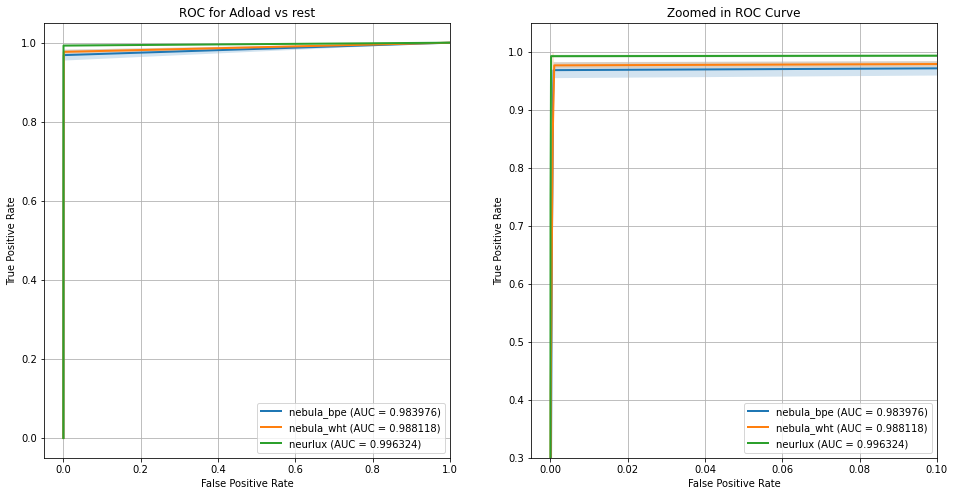

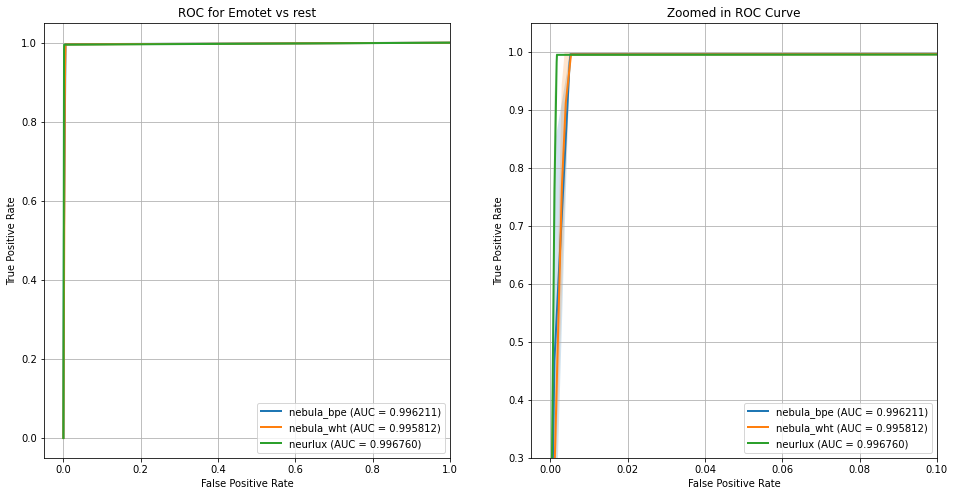

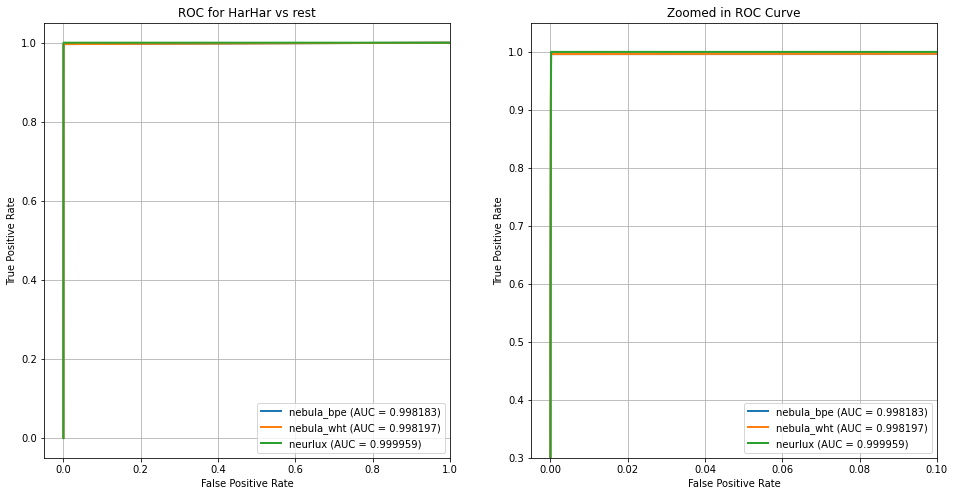

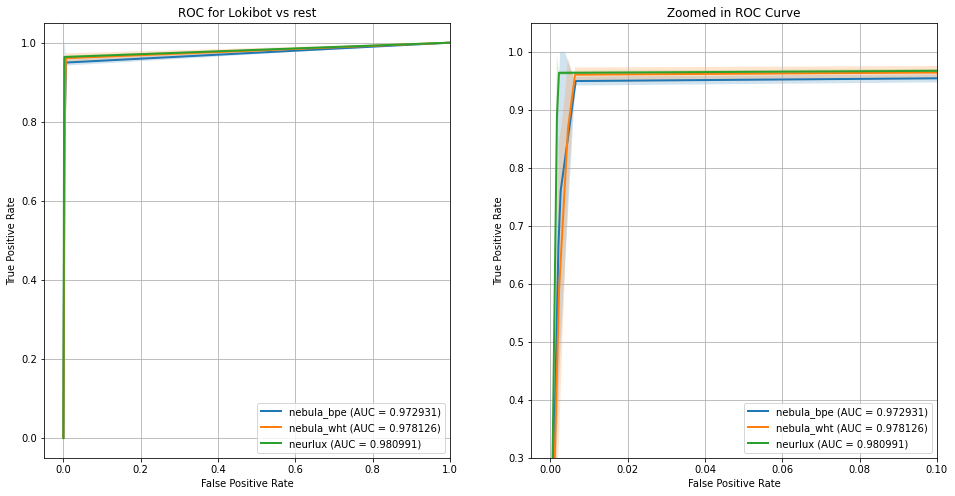

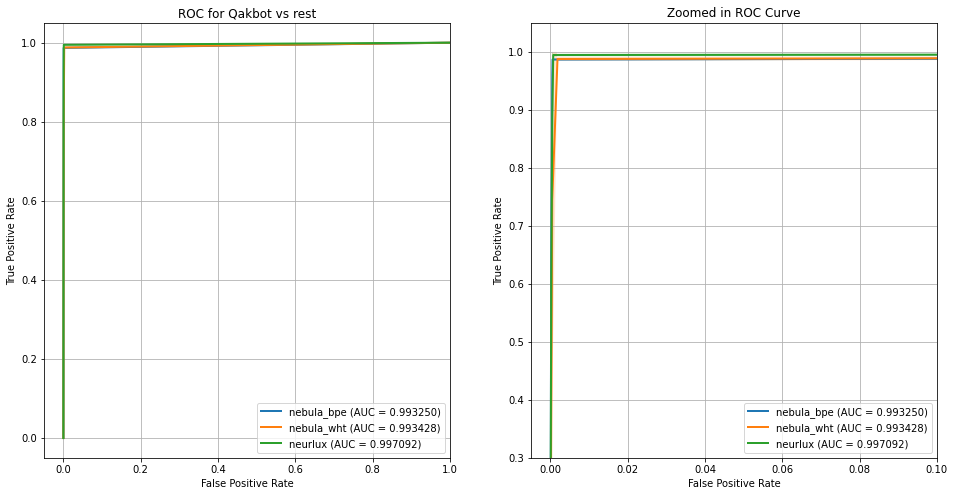

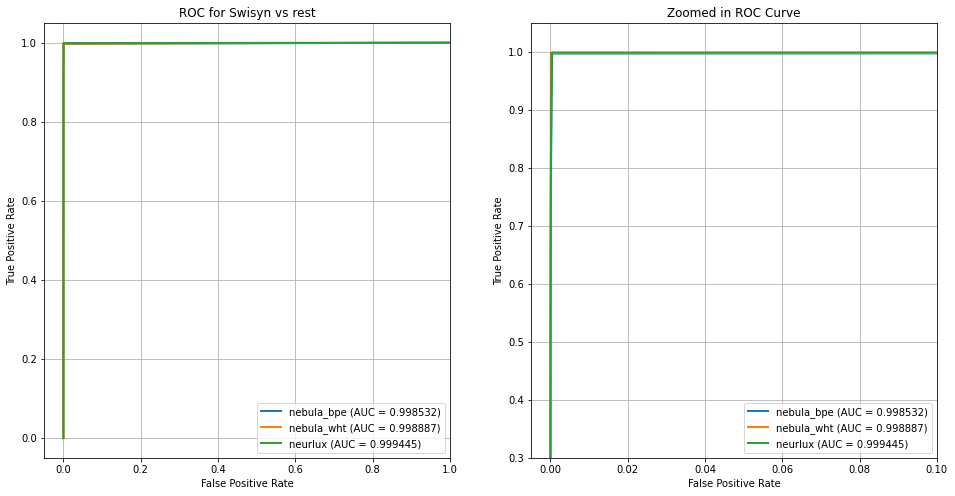

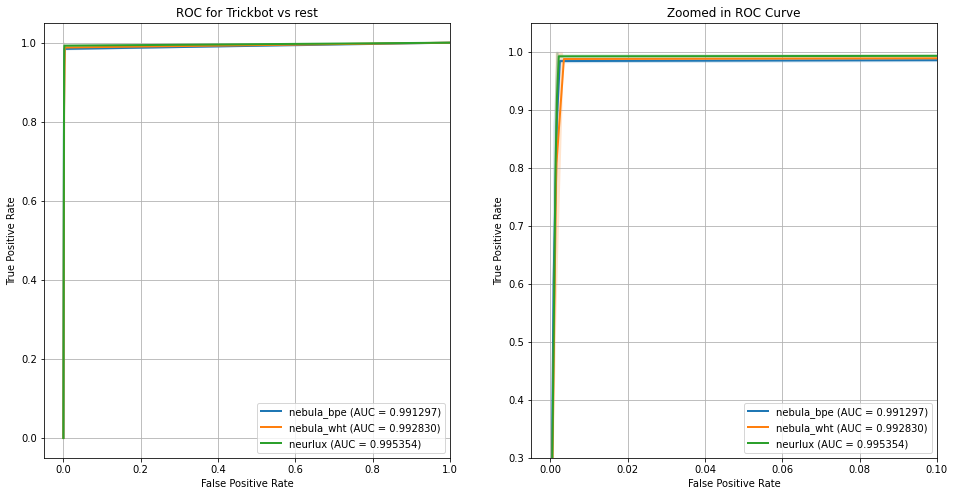

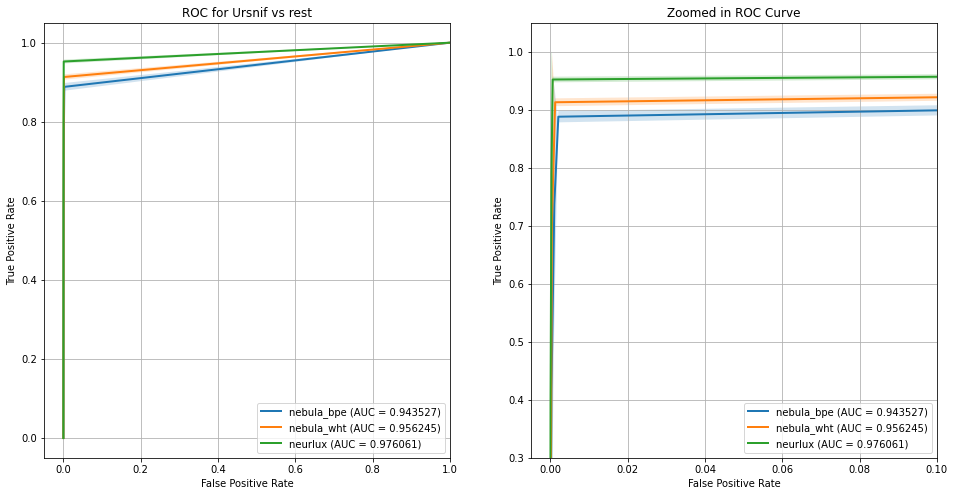

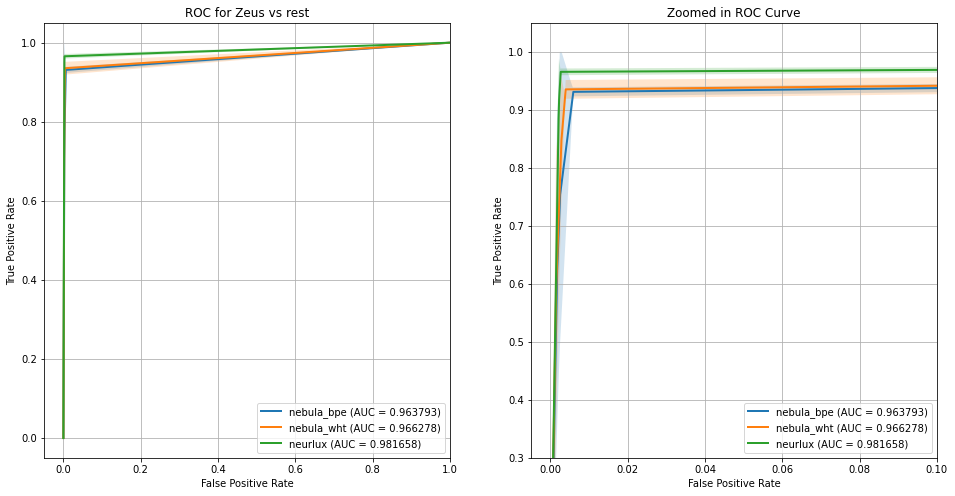

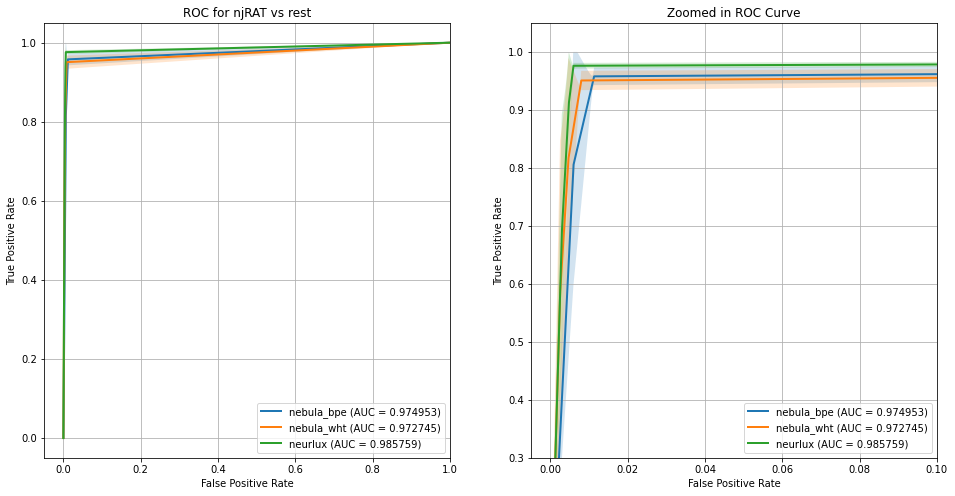

In [4]:
tprs_mean_val_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
tprs_std_val_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
for selected_label in LABEL_MAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_val.items()}
    base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(metrics_label)

    df, axs_val = report_alligned_metrics(
        base_fpr_val,
        tprs_mean_val,
        tprs_std_val,
        metrics_label,
        xlim=[-0.005, 0.1],
        ylim=[0.3, 1.05],
        metrics_full=True
    )
    for k, v in tprs_mean_val.items():
        tprs_mean_val_all[k].append(v)
    for k, v in tprs_std_val.items():
        tprs_std_val_all[k].append(v)
    
    # suptitle to refer label
    axs_val[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[2:3].tolist() + df.columns[-5:].tolist()])

# take mean over all labels
for k, v in tprs_mean_val_all.items():
    tprs_mean_val_all[k] = np.mean(v, axis=0)
for k, v in tprs_std_val_all.items():
    tprs_std_val_all[k] = np.mean(v, axis=0)


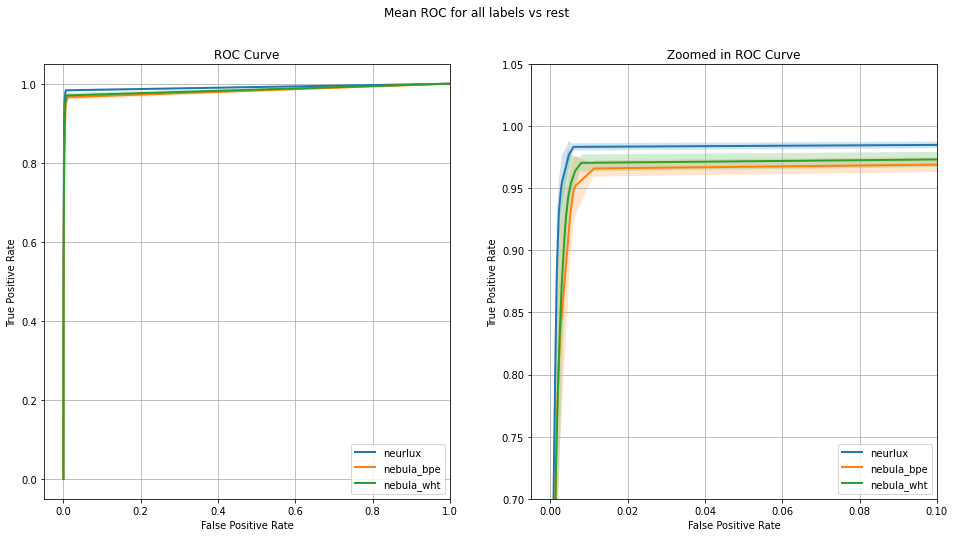

In [9]:
df, axs_val = report_alligned_metrics(
    base_fpr_val,
    tprs_mean_val_all,
    tprs_std_val_all,
    xlim=[-0.005, 0.1],
    ylim=[0.7, 1.05],
    metrics_full=False
)
# get fig of last plot
fig = axs_val[0].get_figure()
# suptitle to refer label
_ = fig.suptitle(f"Mean ROC for all labels vs rest")

## Test set ROCs

In [6]:
metrics_test = defaultdict(list)
model_files = defaultdict(list)
for folder in run_folders:
    key = "_".join(folder.split("_")[1:3]).replace("_lim500", "").replace("_limNone", "")

    existing_pickle = os.path.join(INFOLDER, f"{key}_roc_metrics_test_{RUN_END_FILTER}.pkl")
    if os.path.exists(existing_pickle):
        metrics = pickle.load(open(existing_pickle, "rb"))
    else:
        metrics = defaultdict(list)
        print(f"[*] In process: {key}")
        folder = os.path.join(INFOLDER, folder)

        try:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and "vocab" in x][0]
        except IndexError:
            data_folder = [x for x in os.listdir(INFOLDER) if x.startswith(key) and not x.endswith(".pkl")][0]
        X_test = np.load(os.path.join(INFOLDER, data_folder, f"x_test_{LIMIT}.npy"))
        y_test = np.load(os.path.join(INFOLDER, data_folder, f"y_test_{LIMIT}.npy"))

        train_folder = os.path.join(folder, "training_files")
        model_files[key] = [os.path.join(train_folder, x) for x in os.listdir(train_folder) if x.endswith(".torch")]

        for i, model_file in enumerate(model_files[key]):
            print(f"[*] Running ROC for split: {i}")
            model = models[key]['class'](**models[key]['config']).to(device)
            model.load_state_dict(torch.load(model_file))
            model.eval()
            y_true, y_pred = get_preds(
                model,
                X_test,
                y_test,
                model_name=f"{key}_split_{i}",
                batch_size=96
            )
            y_pred = np.argmax(y_pred, axis=1)
            n_unique_classes = len(np.unique(y_true))
            for n in range(n_unique_classes):
                label = REVERSE_LABEL_MAP[n]
                y_true_n = np.where(y_true == n, 1, 0)
                y_pred_n = np.where(y_pred == n, 1, 0)
                fpr, tpr, roc_auc, f1, recall, precision, acc = get_roc(y_true_n, y_pred_n, metrics_full=True)
                #print(f"For class {label} metrics are: fpr: {fpr}, tpr: {tpr}, roc_auc: {roc_auc}, f1: {f1}, recall: {recall}, precision: {precision}, acc: {acc}")
                metrics[label].append([fpr, tpr, roc_auc, f1, recall, precision, acc])
        pickle.dump(metrics, open(existing_pickle, "wb"))
    metrics_test[key] = metrics

Adload
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.544652  0.865998  0.439000  0.733333   0.451754  0.998546
nebula_wht  0.824753  0.966390  0.697531  0.933333   0.647186  0.999418
neurlux     0.731407  0.999142  0.714976  1.000000   0.692708  0.998284
Emotet
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.180619  0.945309  0.939160  0.895910   0.986935  0.964294
nebula_wht  0.453669  0.938136  0.931919  0.880136   0.990376  0.960427
neurlux     0.724392  0.934505  0.929410  0.869935   0.997615  0.959322
HarHar
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.666984  0.833319  0.776261  0.666667   0.989583  0.997965
nebula_wht  0.739391  0.869565  0.836308  0.739130   1.000000  0.998430
neurlux     0.869652  0.934666  0.903125  0.869565   0.953704  0.998982
Lokibot
               0.001       AUC        F1    Recall  Precision  Accuracy
nebula_bpe  0.158345  0.949921  0.8

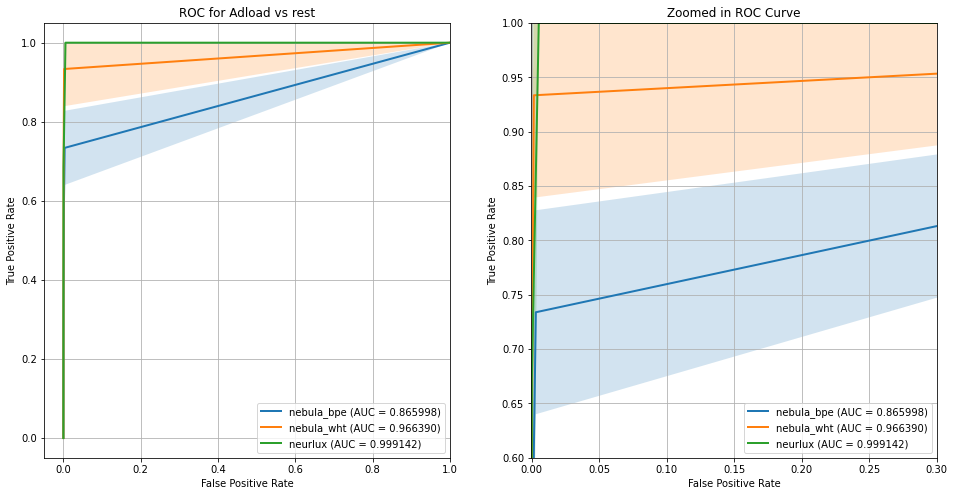

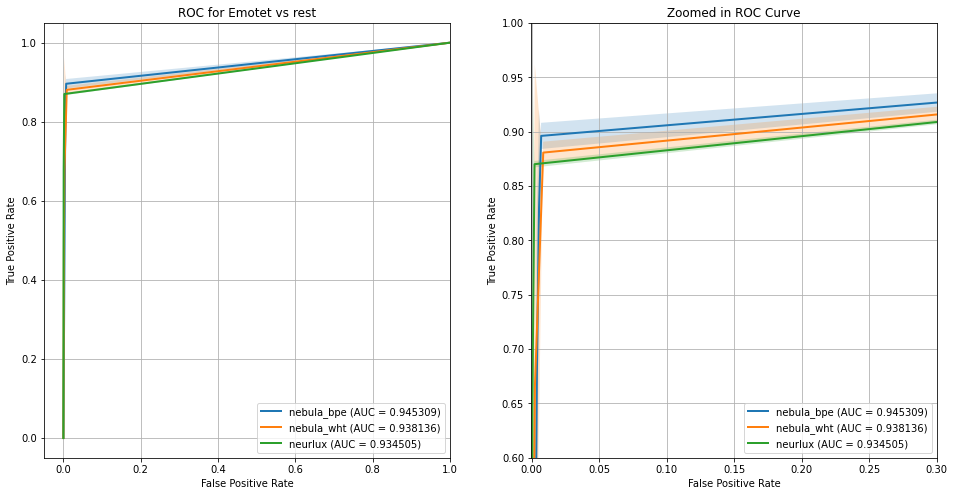

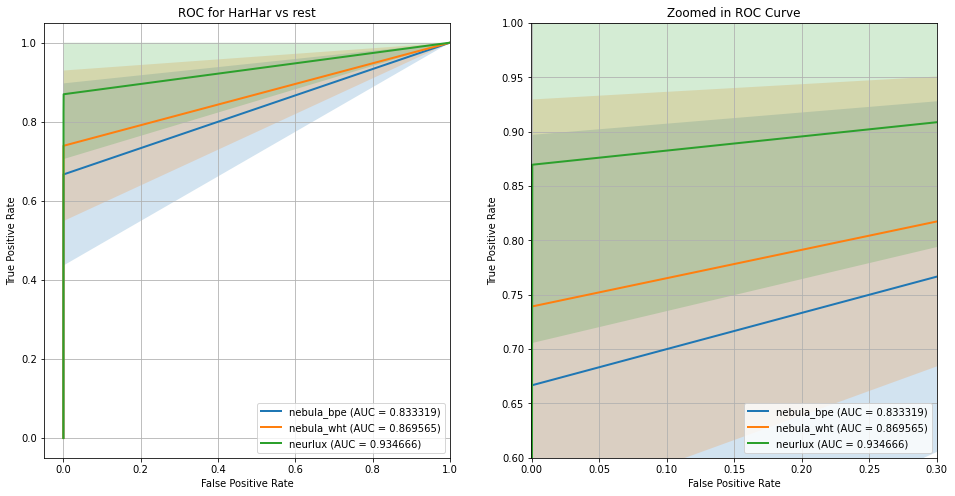

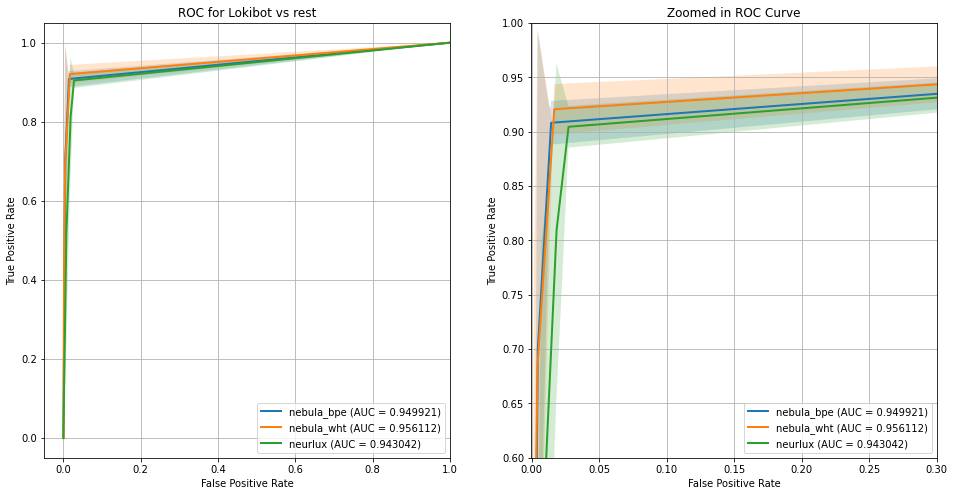

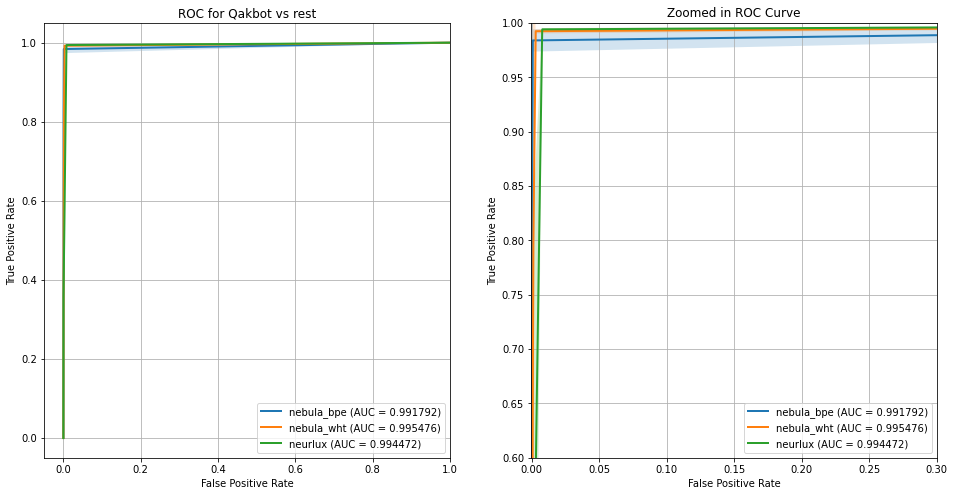

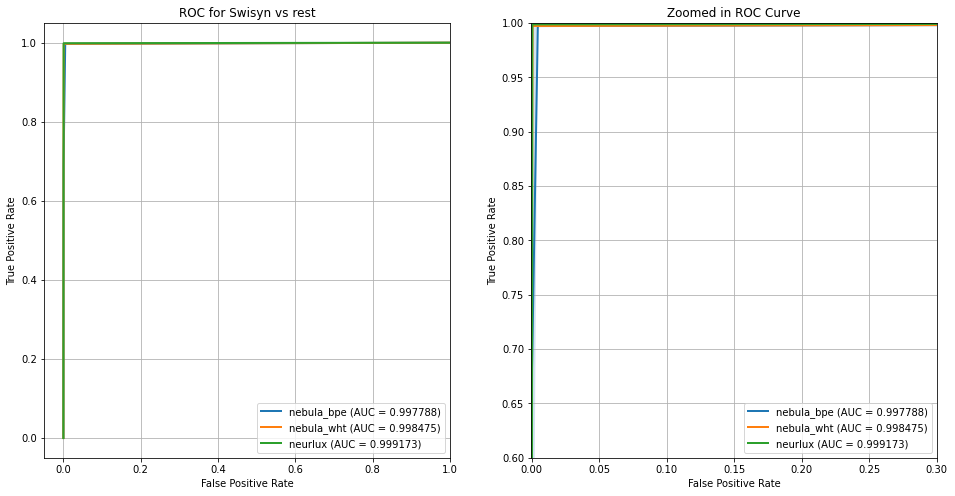

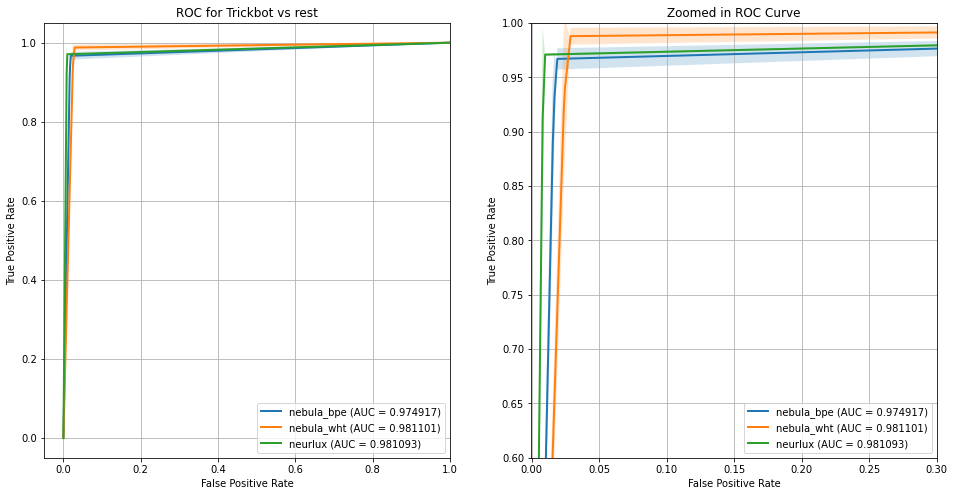

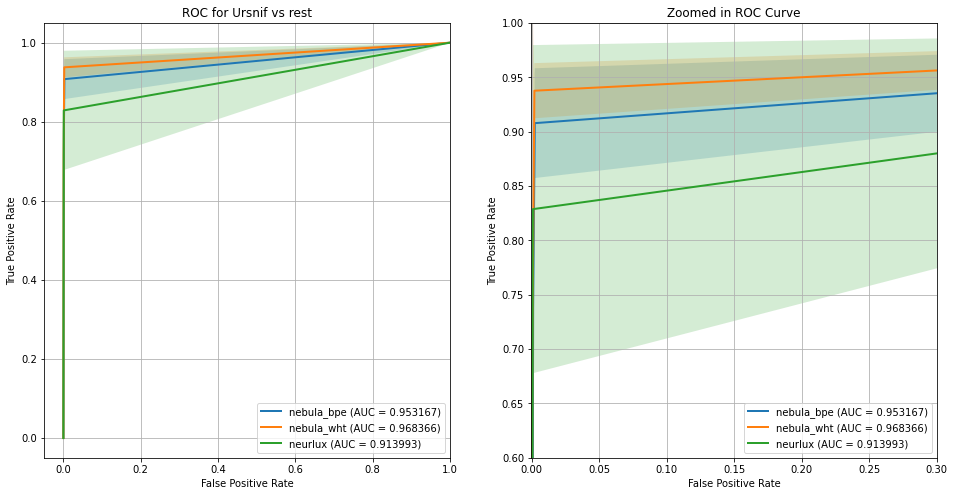

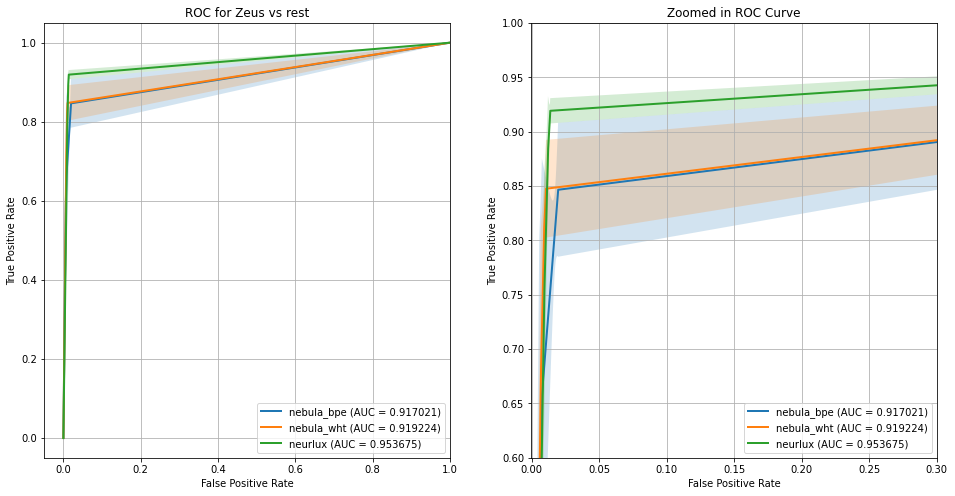

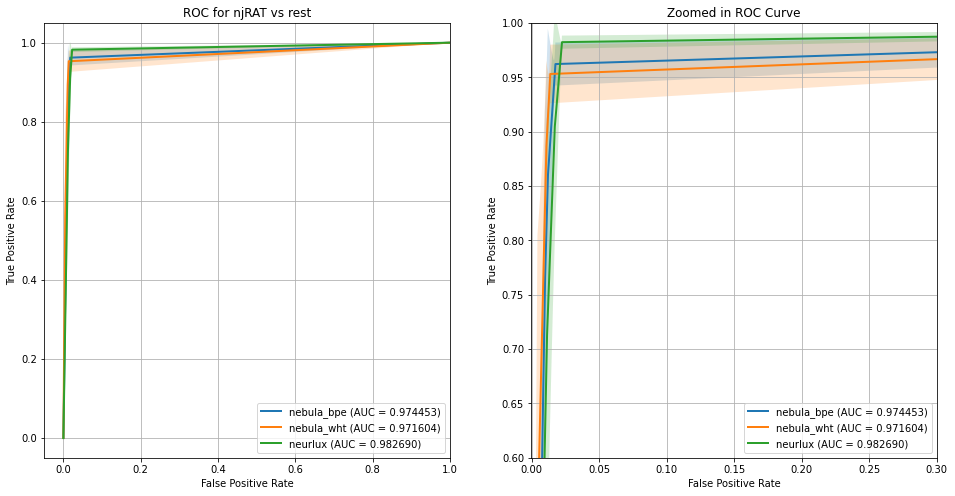

In [7]:
tprs_mean_test_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
tprs_std_test_all = dict(zip(models.keys(), [[] for _ in range(len(models))]))
for selected_label in LABEL_MAP.keys():
    metrics_label = {k: v[selected_label] for k, v in metrics_test.items()}
    base_fpr_test, tprs_mean_test, tprs_std_test = allign_metrics(metrics_label)

    df, axs_test = report_alligned_metrics(
        base_fpr_test,
        tprs_mean_test,
        tprs_std_test,
        metrics_label,
        metrics_full=True
    )
    for k, v in tprs_mean_test.items():
        tprs_mean_test_all[k].append(v)
    for k, v in tprs_std_test.items():
        tprs_std_test_all[k].append(v)

    # suptitle to refer label
    if axs_test is not None:
        axs_test[0].set_title(f"ROC for {selected_label} vs rest")
    print(selected_label)
    print(df[df.columns[2:3].tolist() + df.columns[-5:].tolist()])

# take mean over all labels
for k, v in tprs_mean_test_all.items():
    tprs_mean_test_all[k] = np.mean(v, axis=0)
for k, v in tprs_std_test_all.items():
    tprs_std_test_all[k] = np.mean(v, axis=0)

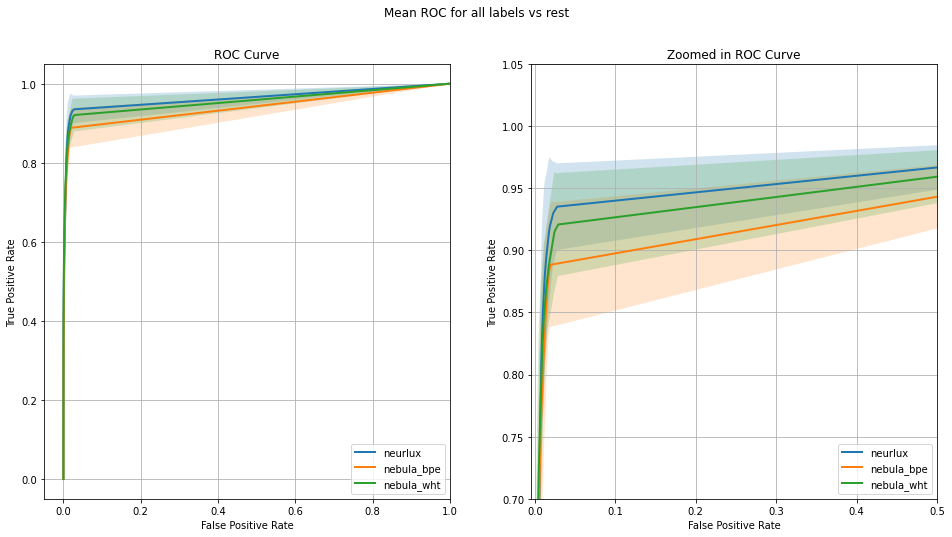

In [10]:
df, axs_test = report_alligned_metrics(
    base_fpr_test,
    tprs_mean_test_all,
    tprs_std_test_all,
    xlim=[-0.005, 0.5],
    ylim=[0.7, 1.05],
    metrics_full=False
)
# get fig of last plot
fig = axs_test[0].get_figure()
# suptitle to refer label
_ = fig.suptitle(f"Mean ROC for all labels vs rest")